## Import Libs

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import random
import pandas as pd
from sklearn.cluster import KMeans


def C_Kmeans(H,cluster_num):
    H=np.real(H)
    sp_kmeans = KMeans(n_clusters=cluster_num).fit(H)
    return sp_kmeans.labels_

In [21]:
# calculate the European distance
def euclidDistance(x1, x2, sqrt_flag=False):
    res = np.sum((x1-x2)**2)
    if sqrt_flag:
        res = np.sqrt(res)
    return res

# distance matrix
def calEuclidDistanceMatrix(X):
    X = np.array(X)
    S = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            S[i][j] = 1.0 * euclidDistance(X[i], X[j])
            if (S[i][j]-0)<=0.0001:
                S[i][j]=0.1
            S[j][i] = S[i][j]
            
    return S


# adjacency matrix with self-tuning
def KNN_STSC(S, k):
    N = len(S)
    A = np.zeros((N,N))

    neighbours_id={}
    for i in range(N):
        neighbours_id[i] = np.argsort(S[i])[:k+1]
    for i in range(N):
        sigmai=np.sqrt(S[i][neighbours_id[i][k]])
        for j in range(N):
            sigmaj=np.sqrt(S[j][neighbours_id[j][k]])
            A[i][j] = np.exp(-S[i][j]/2/sigmai/sigmaj)
            A[j][i] = A[i][j] # mutually

    return A


# adjacency matrix with fixed sigma
def KNN_SC(S,k,sigma):
    N = len(S)
    A = np.zeros((N,N))
    for i in range(N):
        dist_with_index = zip(S[i], range(N))
        dist_with_index = sorted(dist_with_index, key=lambda x:x[0])
        neighbours_id = [dist_with_index[m][1] for m in range(k+1)] 
        for j in neighbours_id: 
            A[i][j] = np.exp(-S[i][j]/2/sigma/sigma)
            A[j][i] = A[i][j]
    return A

# normalize
def calLaplacianMatrix(adjacentMatrix):


    degreeMatrix = np.sum(adjacentMatrix, axis=1)


    laplacianMatrix = np.diag(degreeMatrix) - adjacentMatrix
    sqrtDegreeMatrix = np.diag(1.0 / (degreeMatrix ** (0.5)))
    return np.dot(np.dot(sqrtDegreeMatrix, laplacianMatrix), sqrtDegreeMatrix)

# Eigen-decomposition
def getEigVec(L,cluster_num):
    eigval,eigvec=np.linalg.eig(L)
    dim=len(eigval)
    dictEigval=dict(zip(eigval,range(0,dim)))
    kEig=np.sort(eigval)[0:cluster_num]
    ix=[dictEigval[k] for k in kEig]
    return eigval[ix],eigvec[:,ix]

In [22]:
# Vanilla Spectral Clustering
def SC(data,cluster_num,k,sigma):
    disMatrix=calEuclidDistanceMatrix(data)
    adjMatrix=KNN_SC(disMatrix,k,sigma)
    LaplacianMatrix=calLaplacianMatrix(adjMatrix)
    lam, H = getEigVec(LaplacianMatrix,cluster_num) # H'shape is n*n
    labels=C_Kmeans(H,cluster_num)
    return labels

# Self-Tuning Spectral Clustering
def STSC(data,cluster_num,k):
    disMatrix=calEuclidDistanceMatrix(data)
    adjMatrix=KNN_STSC(disMatrix,k)
    LaplacianMatrix=calLaplacianMatrix(adjMatrix)
    lam, H = getEigVec(LaplacianMatrix,cluster_num) # H'shape is n*n
    labels=C_Kmeans(H,cluster_num)
    plt.figure(figsize=(5,5))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.scatter([x[0] for x in data],[x[1] for x in data],c=labels,label='same class')

    return labels


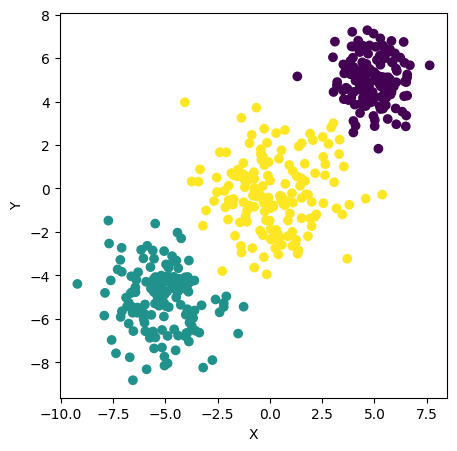

<Figure size 500x500 with 0 Axes>

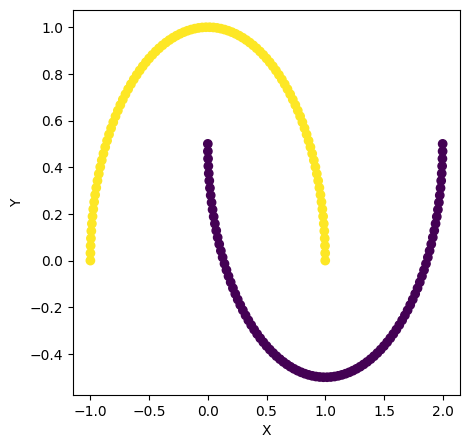

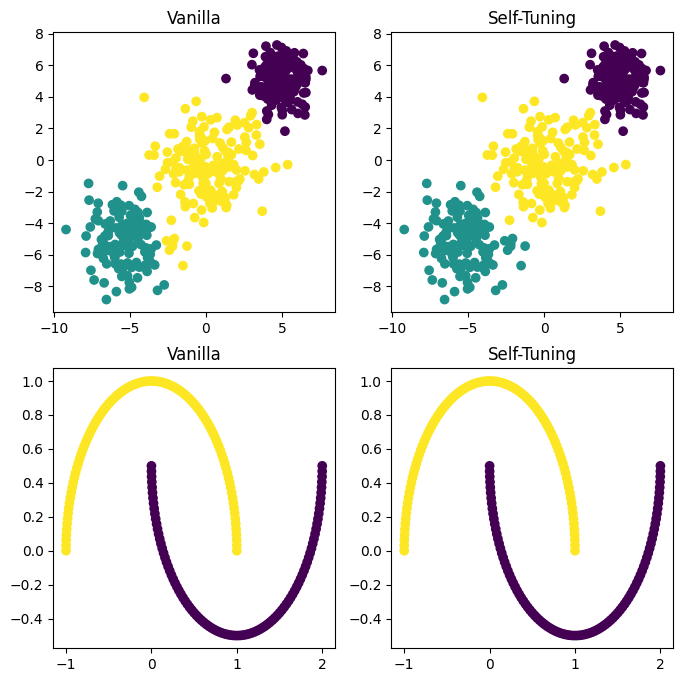

In [23]:
cluster_1 = (2**0.5)*np.random.randn(150,2)-[5,5]
cluster_2 = (3**0.5)*np.random.randn(150,2)
cluster_3 = np.random.randn(150,2)+[5,5]      
moon_dataset = datasets.make_moons(200)
moon_dataset_point = moon_dataset[0]

data_all = np.concatenate((np.concatenate((cluster_1,cluster_2)),cluster_3))
np.random.shuffle(data_all)      

norm_label_SC = SC(data_all,3,4,2)
norm_label_STSC = STSC(data_all,3,4)
plt.figure(figsize=(5,5))
moon_label_SC = SC(moon_dataset_point,2,4,2)
moon_label_STSC = STSC(moon_dataset_point,2,4)

fig , axes = plt.subplots(2,2,figsize=(8,8))

axes[0,0].scatter(data_all[:,0],data_all[:,1],c=norm_label_SC)
axes[0,0].set_title('Vanilla')
axes[0,1].scatter(data_all[:,0],data_all[:,1],c=norm_label_STSC)
axes[0,1].set_title('Self-Tuning')
axes[1,0].scatter(moon_dataset_point[:,0],moon_dataset_point[:,1],c=moon_label_SC)
axes[1,0].set_title('Vanilla')
axes[1,1].scatter(moon_dataset_point[:,0],moon_dataset_point[:,1],c=moon_label_STSC)
axes[1,1].set_title('Self-Tuning')
plt.show()

In [24]:
# calculate purity
import collections as clc
def purity(label_origin,label):
    count=0
    for i in np.unique(label):
        index_i=[j for j,x in enumerate(label) if x==i ]
        catch=[]
        for i in index_i:
            catch.append(label_origin[i])
        x=clc.Counter(catch).most_common()
        count+=x[0][1]
    return '%.2f'%(count/len(label_origin)*100)+'%'

# DBI
def calDBI(data,label):
    centers={}
    S={}
    for i in np.unique(label):
        index_i=[j for j,x in enumerate(label) if x==i ]
        vector=np.zeros((len(data[0])))
        for j in index_i:
            vector+=data[j]
        vector=vector/len(index_i)
        centers[i]=vector
        distance=0
        for j in index_i:
            distance+=euclidDistance(data[j],vector)
        S[i]=np.sqrt(distance/len(index_i))

    R=[]
    for i in np.unique(label):
        Ri_lst=[]
        for j in np.unique(label) :
            if j!=i:
                M=euclidDistance(centers[i],centers[j],sqrt_flag=True)
                Sj=(S[i]+S[j])/M
                Ri_lst.append(Sj)
        Ri=max(Ri_lst)
        R.append(Ri)
    DBI=np.sum(R)/len(R)
    return '%.2f'%(DBI*100)

In [25]:
# initialize affiliation matrix
def initialize_U(samples,classes):
    #samples: the number of samples
    #classes: the numer of clusters
    u=np.random.rand(samples,classes)
    sumu=1/np.sum(u,axis=1)
    u=np.multiply(u.T,sumu)
    return u.T

def distance(X,centroids):
    return np.sqrt(np.sum((X-centroids)**2,axis=1))

# update affiliation matrix
def computeU(X, centroids, m=2):
    sampleNumber = X.shape[0]  # 样本数
    classes = len(centroids)
    U = np.zeros((sampleNumber, classes))
    # 更新隶属度矩阵
    for i in range(classes):
        for k in range(classes):
            U[:, i] += (distance(X, centroids[i]) / distance(X, centroids[k])) ** (2 / (m - 1))
    U = 1 / U
 
    return U

# update the center of cluters
def generateCentroid(centroids, data,U, m):
    
    sampleNumber = X.shape[0]
    centroidsNum=len(centroids)
    newCentroids=[]
    for j in range(centroidsNum):
        centroid = np.dot(U[:, i]**m, data) / (np.sum(U[:, i]**m))
        newCentroids.append(centroid)
    return newCentroids
 

def cluster(data, m, classes, EPS):
    """
    :param data: dataset
    :param m: fuzziness coefficient
    :param classes: the number of classes
    :return: the center of clusters
    """
    sampleNumber = data.shape[0]  
    cNumber = data.shape[1]      
    U = initialize_U(sampleNumber, classes)  
    U_old = np.zeros((sampleNumber, classes))
 
    while True:
        centroids = []
        for i in range(classes):
            centroid = np.dot(U[:, i]**m, data) / (np.sum(U[:, i]**m))
            centroids.append(centroid)
 
        U_old = U.copy()
        U = computeU(data, centroids, m) 
        if np.max(np.abs(U - U_old)) < EPS:
            return centroids,U
        
def predict(X, centroids):
    labels = np.zeros(X.shape[0])
    U = computeU(X, centroids) 
    labels = np.argmax(U, axis=1)  
    return labels

def FCM(data,m,EPS,classes):
    centroids, U = cluster(data,  m, classes, EPS)
    labels = predict(data, centroids)
    return labels


{'moon_FCM': '75.00%',
 'moon_SC': '100.00%',
 'moon_STSC': '100.00%',
 'digits_FCM': '30.50%',
 'digits_SC': '11.02%',
 'digits_STSC': '69.28%',
 'iris_FCM': '90.67%',
 'iris_SC': '90.00%',
 'iris_STSC': '90.00%'}

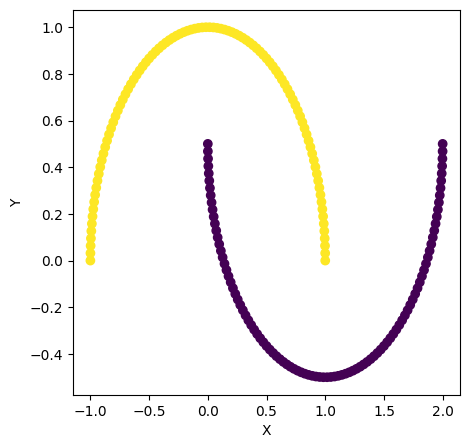

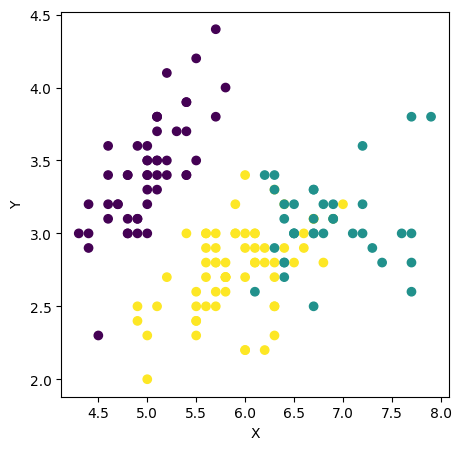

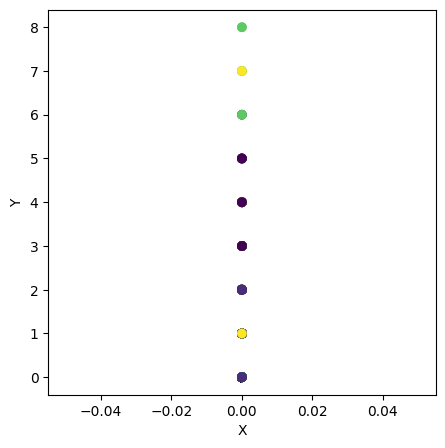

In [26]:
from sklearn import datasets
import sklearn.datasets as sd

import matplotlib.pyplot as plt
digits=datasets.load_digits()
iris=datasets.load_iris()
moon_data,moon_label=sd.make_moons(n_samples=200)

moon_label_FCM=FCM(moon_data,5,1e-8,2)
moon_label_STSC=STSC(moon_data,2,5)
moon_label_SC=SC(moon_data,2,5,1)
iris_label_STSC=STSC(iris['data'].tolist(),3,4)
iris_label_SC=SC(iris['data'].tolist(),3,4,2)
iris_label_FCM=FCM(iris['data'],4,1e-9,3)
digits_label_STSC=STSC(digits['data'].tolist(),9,4)
digits_label_SC=SC(digits['data'].tolist(),9,4,2)
digits_label_FCM=FCM(digits['data'],4,1e-9,9)


purity_all={}

purity_all['moon_FCM']=purity(moon_label,moon_label_FCM)
purity_all['moon_SC']=purity(moon_label,moon_label_SC)
purity_all['moon_STSC']=purity(moon_label,moon_label_STSC)
purity_all['digits_FCM']=purity(digits['target'],digits_label_FCM)
purity_all['digits_SC']=purity(digits['target'],digits_label_SC)
purity_all['digits_STSC']=purity(digits['target'],digits_label_STSC)
purity_all['iris_FCM']=purity(iris['target'],iris_label_FCM)
purity_all['iris_SC']=purity(iris['target'],iris_label_SC)
purity_all['iris_STSC']=purity(iris['target'],iris_label_STSC)
purity_all

In [27]:
DBI_all={}
DBI_all['moon_FCM']=calDBI(moon_data,moon_label_FCM)
DBI_all['moon_SC']=calDBI(moon_data,moon_label_SC)
DBI_all['moon_STSC']=calDBI(moon_data,moon_label_STSC)
DBI_all['digits_FCM']=calDBI(digits['data'],digits_label_FCM)
DBI_all['digits_SC']=calDBI(digits['data'],digits_label_SC)
DBI_all['digits_STSC']=calDBI(digits['data'],digits_label_STSC)
DBI_all['iris_FCM']=calDBI(iris['data'],iris_label_FCM)
DBI_all['iris_SC']=calDBI(iris['data'],iris_label_SC)
DBI_all['iris_STSC']=calDBI(iris['data'],iris_label_STSC)
DBI_all

{'moon_FCM': '81.71',
 'moon_SC': '123.61',
 'moon_STSC': '123.61',
 'digits_FCM': '280.19',
 'digits_SC': '133.99',
 'digits_STSC': '185.45',
 'iris_FCM': '74.45',
 'iris_SC': '72.37',
 'iris_STSC': '72.37'}